In [34]:
import numpy as np
import pandas as pd
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate, KFold, LeaveOneOut
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, make_scorer, pairwise
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('C:/Users/dcfra/GR_capstone_public/data/ML_data.csv') # already scaled
del data['Unnamed: 0']
n = data.shape[0]
y_vars = ['AAL','SPEEDMAX','JUMPS','PHYSIOLOAD','EXERTIONS','DISTANCE']
Y = np.array(data[y_vars]) # 108 x 6
feat_df = pd.get_dummies(data[['HALF','ATHLETE']],dtype=float).join(data.drop(pd.Index(y_vars + ['ATHLETE','DATE','HALF']),axis=1))
X_one = np.ones((data.shape[0],1))
X_red = np.array(pd.get_dummies(data[['HALF','ATHLETE']],dtype=float).join(pd.Series(data['TIME'])))
X_full = np.array(feat_df) 


In [58]:
data.head().drop("ATHLETE",axis=1)

,DATE,HALF,TIME,AAL,SPEEDMAX,JUMPS,PHYSIOLOAD,EXERTIONS,DISTANCE,PEAK_POWER_BM,...,P_1_CONCENTRIC_IMPULSE,TAKEOFF_PEAK_FORCE_BM,CONCENTRIC_PEAK_FORCE_BM,ECCENTRIC_PEAK_FORCE_BM,VELOCITY_AT_PEAK_POWER,ECCENTRIC_PEAK_VELOCITY,ECCENTRIC_BRAKING_IMPULSE,CONCENTRIC_MEAN_FORCE_BM,ECCENTRIC_DECELERATION_IMPULSE_BM,CONCENTRIC_IMPULSE_ABS_BM
0,2023-11-08,2,0.565637,-0.293417,-1.245821,-0.602085,-1.170007,0.377891,-0.449857,0.644089,...,-1.438856,-0.648129,-0.640035,-1.460928,-0.046799,1.593554,-0.379485,-0.560932,-1.614025,0.712274
1,2023-11-08,2,0.565637,-0.293417,-1.245821,-0.602085,-1.170007,0.377891,-0.449857,0.287437,...,-1.681630,-0.753720,-0.751472,-1.601165,0.090552,0.905734,-0.371664,-0.977721,-0.863950,1.057727
2,2023-11-08,1,0.224549,1.631903,-0.565816,0.042329,0.478027,1.249197,1.513430,0.644089,...,-1.438856,-0.648129,-0.640035,-1.460928,-0.046799,1.593554,-0.379485,-0.560932,-1.614025,0.712274
3,2023-11-08,1,0.224549,1.631903,-0.565816,0.042329,0.478027,1.249197,1.513430,0.287437,...,-1.681630,-0.753720,-0.751472,-1.601165,0.090552,0.905734,-0.371664,-0.977721,-0.863950,1.057727
4,2023-11-12,2,1.983045,0.967964,-0.799927,0.300095,-0.005958,1.705595,0.936863,-0.531152,...,-1.694002,-1.069588,-1.084826,-1.381778,-0.633916,0.980163,-0.835010,-1.156412,-0.925038,1.007444


In [5]:
def response_cv(cv,var):
    if type(var) == str:
        return -np.mean(cv[f'test_{var}'])
    else:
        return [-np.mean(cv[f'test_{var_i}']) for var_i in var]
    
def rmse_score(y_true, y_pred,output_index):
    return mean_squared_error(y_true[:, output_index], y_pred[:, output_index],squared = False)

scorers = {
    f'{y_vars[i]}': make_scorer(rmse_score, output_index=i, greater_is_better=False,response_method="predict")
    for i in range(Y.shape[1])
}

loo = LeaveOneOut()
cv_one = cross_validate(MultiOutputRegressor(LinearRegression()), X_one,Y, cv=loo, scoring=scorers, return_train_score=False,verbose = 0,n_jobs = -1)
cv_redreg = cross_validate(MultiOutputRegressor(LinearRegression()), X_red,Y, cv=loo, scoring=scorers, return_train_score=False,verbose = 0,n_jobs = -1)
cv_fullreg = cross_validate(MultiOutputRegressor(LinearRegression()), X_full,Y, cv=loo, scoring=scorers, return_train_score=False,verbose = 0,n_jobs = -1)


In [51]:
alphas = np.logspace(-4, 4, 100)

# Placeholder for the average LOOCV RMSE for each response and each alpha
avg_loocv_rmse = np.zeros((6, len(alphas)))

# Perform LOOCV for each response
loo = LeaveOneOut()
for i, alpha in enumerate(alphas):
    rmses = np.zeros(6)
    for response_index in range(6):
        y = Y[:, response_index]
        y_preds = np.zeros(n)
        for train_index, test_index in loo.split(X_full):
            X_train, X_test = X_full[train_index], X_full[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model = Ridge(alpha=alpha)
            model.fit(X_train, y_train)
            y_preds[test_index] = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y, y_preds))
        rmses[response_index] = rmse
    avg_loocv_rmse[:, i] = rmses

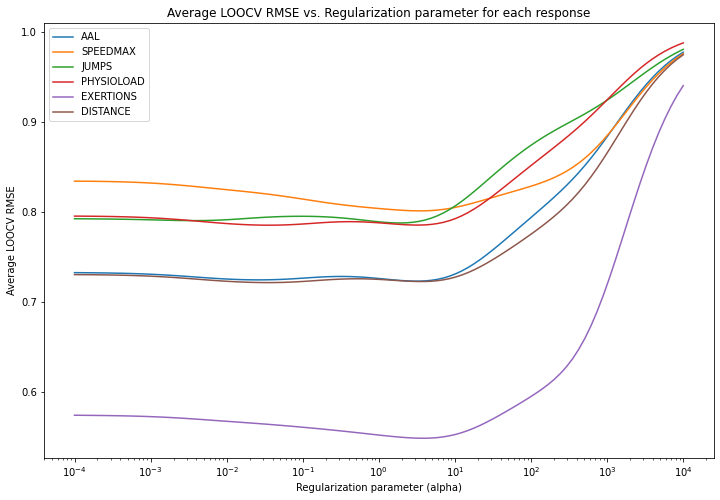

In [52]:
# Plot the average LOOCV RMSE for each response
plt.figure(figsize=(12, 8))
for response_index in range(6):
    plt.plot(alphas, avg_loocv_rmse[response_index], label = y_vars[response_index])
plt.xscale('log')
plt.xlabel('Regularization parameter (alpha)')
plt.ylabel('Average LOOCV RMSE')
plt.title('Average LOOCV RMSE vs. Regularization parameter for each response')
plt.legend()
plt.grid(False)
plt.show()

In [53]:
min_index = int(np.squeeze(np.where(avg_loocv_rmse[4] == min(avg_loocv_rmse[4]))))
alpha = alphas[min_index]
print(alpha)

4.037017258596558


In [54]:
# model = MultiOutputRegressor(LinearRegression())
# model = MultiOutputRegressor(GradientBoostingRegressor())
# model = RandomForestRegressor(n_estimators = 100,max_depth=20,n_jobs=-1)
# model = RegressorChain(LinearRegression())
model = Ridge(alpha = alpha)
# model = PLSRegression(5,scale=False)
# model = KernelRidge(kernel="poly")


In [55]:
rfe_model = RFE(model,step=1,verbose=0,n_features_to_select=10)
selector = rfe_model.fit(X_full,Y)
feat_df.columns[selector.support_]

Index(['ATHLETE_Akuel Kot', 'ATHLETE_Brendan Wenzel', 'ATHLETE_Caden Powell',
       'ATHLETE_Sam Griffin', 'TIME', 'CONCENTRIC_MEAN_FORCE',
       'ECCENTRIC_PEAK_FORCE_BM', 'VELOCITY_AT_PEAK_POWER',
       'ECCENTRIC_PEAK_VELOCITY', 'ECCENTRIC_BRAKING_IMPULSE'],
      dtype='object')

In [56]:
cv_red = cross_validate(model, X_red,Y, cv=loo, scoring=scorers, return_train_score=False,verbose = 0,n_jobs = -1)
cv_full = cross_validate(model, X_full,Y, cv=loo, scoring=scorers, return_train_score=False,verbose = 0,n_jobs = -1)

X_cut = np.array(feat_df[feat_df.columns[selector.support_]])
cv_cut = cross_validate(model, X_cut,Y, cv=loo, scoring=scorers, return_train_score=False,verbose = 0,n_jobs = -1)
print(f'Intercept Only Prediction Error: {[np.sqrt(mean_squared_error(Y[:,i],LinearRegression().fit(X_one,Y[:,i]).predict(X_one))) for i in range(0,6)]}')
print(f'Intercept Only Regression: {response_cv(cv_one,y_vars)}')
print(f'Kinexon Only Regression: {response_cv(cv_redreg,y_vars)}')
print(f'Full Model Regression: {response_cv(cv_fullreg,y_vars)}')
print('')
print(f'Kinexon Only Model: {response_cv(cv_red,y_vars)}')
print(f'Full Model: {response_cv(cv_full,y_vars)}')
print(f'Reduced Model: {response_cv(cv_cut,y_vars)}')

Intercept Only Prediction Error: [0.9975460085708762, 0.9975460085708765, 0.997546008570876, 0.9975460085708764, 0.9975460085708764, 0.997546008570876]
Intercept Only Regression: [0.835295990335643, 0.8071850456215919, 0.8124604106233384, 0.8160046651968675, 0.8282360058217879, 0.8450553022485202]
Kinexon Only Regression: [0.5861560629675495, 0.6022627595808933, 0.6436007115149778, 0.6387987010792846, 0.46180361231789335, 0.5787073403855884]
Full Model Regression: [0.5911102423285426, 0.6539347099021962, 0.6466507492696658, 0.6322898014244858, 0.47374822279448575, 0.5803267685312161]

Kinexon Only Model: [0.5897577212757277, 0.6060246440532343, 0.6429510497506082, 0.6414059618584571, 0.47303780330840306, 0.5849362943070834]
Full Model: [0.5917984182119357, 0.6224511623877831, 0.654960596662756, 0.640245869558625, 0.4523176724794019, 0.5892456211117147]
Reduced Model: [0.5791331404256075, 0.6045768730021615, 0.6423165970085327, 0.6256282276520275, 0.4563091877170453, 0.5781078320070583]